## Wrapper Methods

In this project, we will analyze data from a survey conducted by Fabio Mendoza Palechor and Alexis de la Hoz Manotas that asked people about their eating habits and weight. The data was obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+). Categorical variables are already changed to numerical ones in order to facilitate analysis.

First, we will fit a logistic regression model to try to predict whether survey respondents are obese based on their answers to questions in the survey. After that, we are going to use three different wrapper methods to choose a smaller feature subset and compare the performance of the model trained using the subset of features chosen by each of the algorithms.

To do this we will use sequential forward selection, sequential backward floating selection, and recursive feature elimination.

### Data - What are we working with?

The data set contains 18 predictor variables. Here's a brief description of them.

- `Gender` is `1` if a respondent is male and `0` if a respondent is female.
- `Age` is a respondent's age in years.
- `family_history_with_overweight` is `1` if a respondent has family member who is or was overweight, `0` if not.
- `FAVC` is `1` if a respondent eats high caloric food frequently, `0` if not.
- `FCVC` is `1` if a respondent usually eats vegetables in their meals, `0` if not.
- `NCP` represents how many main meals a respondent has daily (`0` for 1-2 meals, `1` for 3 meals, and `2` for more than 3 meals).
- `CAEC` represents how much food a respondent eats between meals on a scale of `0` to `3`.
- `SMOKE` is `1` if a respondent smokes, `0` if not.
- `CH2O` represents how much water a respondent drinks on a scale of `0` to `2`.
- `SCC` is `1` if a respondent monitors their caloric intake, `0` if not.
- `FAF` represents how much physical activity a respondent does on a scale of `0` to `3`.
- `TUE` represents how much time a respondent spends looking at devices with screens on a scale of `0` to `2`.
- `CALC` represents how often a respondent drinks alcohol on a scale of `0` to `3`.
- `Automobile`, `Bike`, `Motorbike`, `Public_Transportation`, and `Walking` indicate a respondent's primary mode of transportation. Their primary mode of transportation is indicated by a `1` and the other columns will contain a `0`.

The outcome variable, `NObeyesdad`, is a `1` if a patient is obese and a `0` if not.

In [10]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

In [5]:
## https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+

## Load the data
obesity = pd.read_csv("ObesityDataSet.csv")

## Inspect the data
print(obesity.head())
# print(obesity.columns)


   Gender   Age  family_history_with_overweight  FAVC  FCVC  NCP  CAEC  SMOKE   
0       0  21.0                               1     0   2.0  3.0     1      0  \
1       0  21.0                               1     0   3.0  3.0     1      1   
2       1  23.0                               1     0   2.0  3.0     1      0   
3       1  27.0                               0     0   3.0  3.0     1      0   
4       1  22.0                               0     0   2.0  1.0     1      0   

   CH2O  SCC  FAF  TUE  CALC  Automobile  Bike  Motorbike   
0   2.0    0  0.0  1.0     0           0     0          0  \
1   3.0    1  3.0  0.0     1           0     0          0   
2   2.0    0  2.0  1.0     2           0     0          0   
3   2.0    0  2.0  0.0     2           0     0          0   
4   2.0    0  0.0  0.0     1           0     0          0   

   Public_Transportation  Walking  NObeyesdad  
0                      1        0           0  
1                      1        0           0  
2 

### Exploratory Data Analysis.

In [9]:
obesity.describe()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking,NObeyesdad
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,0.505921,24.312600,0.817622,0.883941,2.419043,2.685628,1.140692,0.020843,2.008011,0.045476,1.010298,0.657866,0.731407,0.216485,0.003316,0.005211,0.748460,0.026528,0.460445
std,0.500083,6.345968,0.386247,0.320371,0.533927,0.778039,0.468543,0.142893,0.612953,0.208395,0.850592,0.608927,0.515498,0.411946,0.057502,0.072015,0.434001,0.160737,0.498551
min,0.000000,14.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.947192,1.000000,1.000000,2.000000,2.658738,1.000000,0.000000,1.584812,0.000000,0.124505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,22.777890,1.000000,1.000000,2.385502,3.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.625350,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,26.000000,1.000000,1.000000,3.000000,3.000000,1.000000,0.000000,2.477420,0.000000,1.666678,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,61.000000,1.000000,1.000000,3.000000,4.000000,3.000000,1.000000,3.000000,1.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


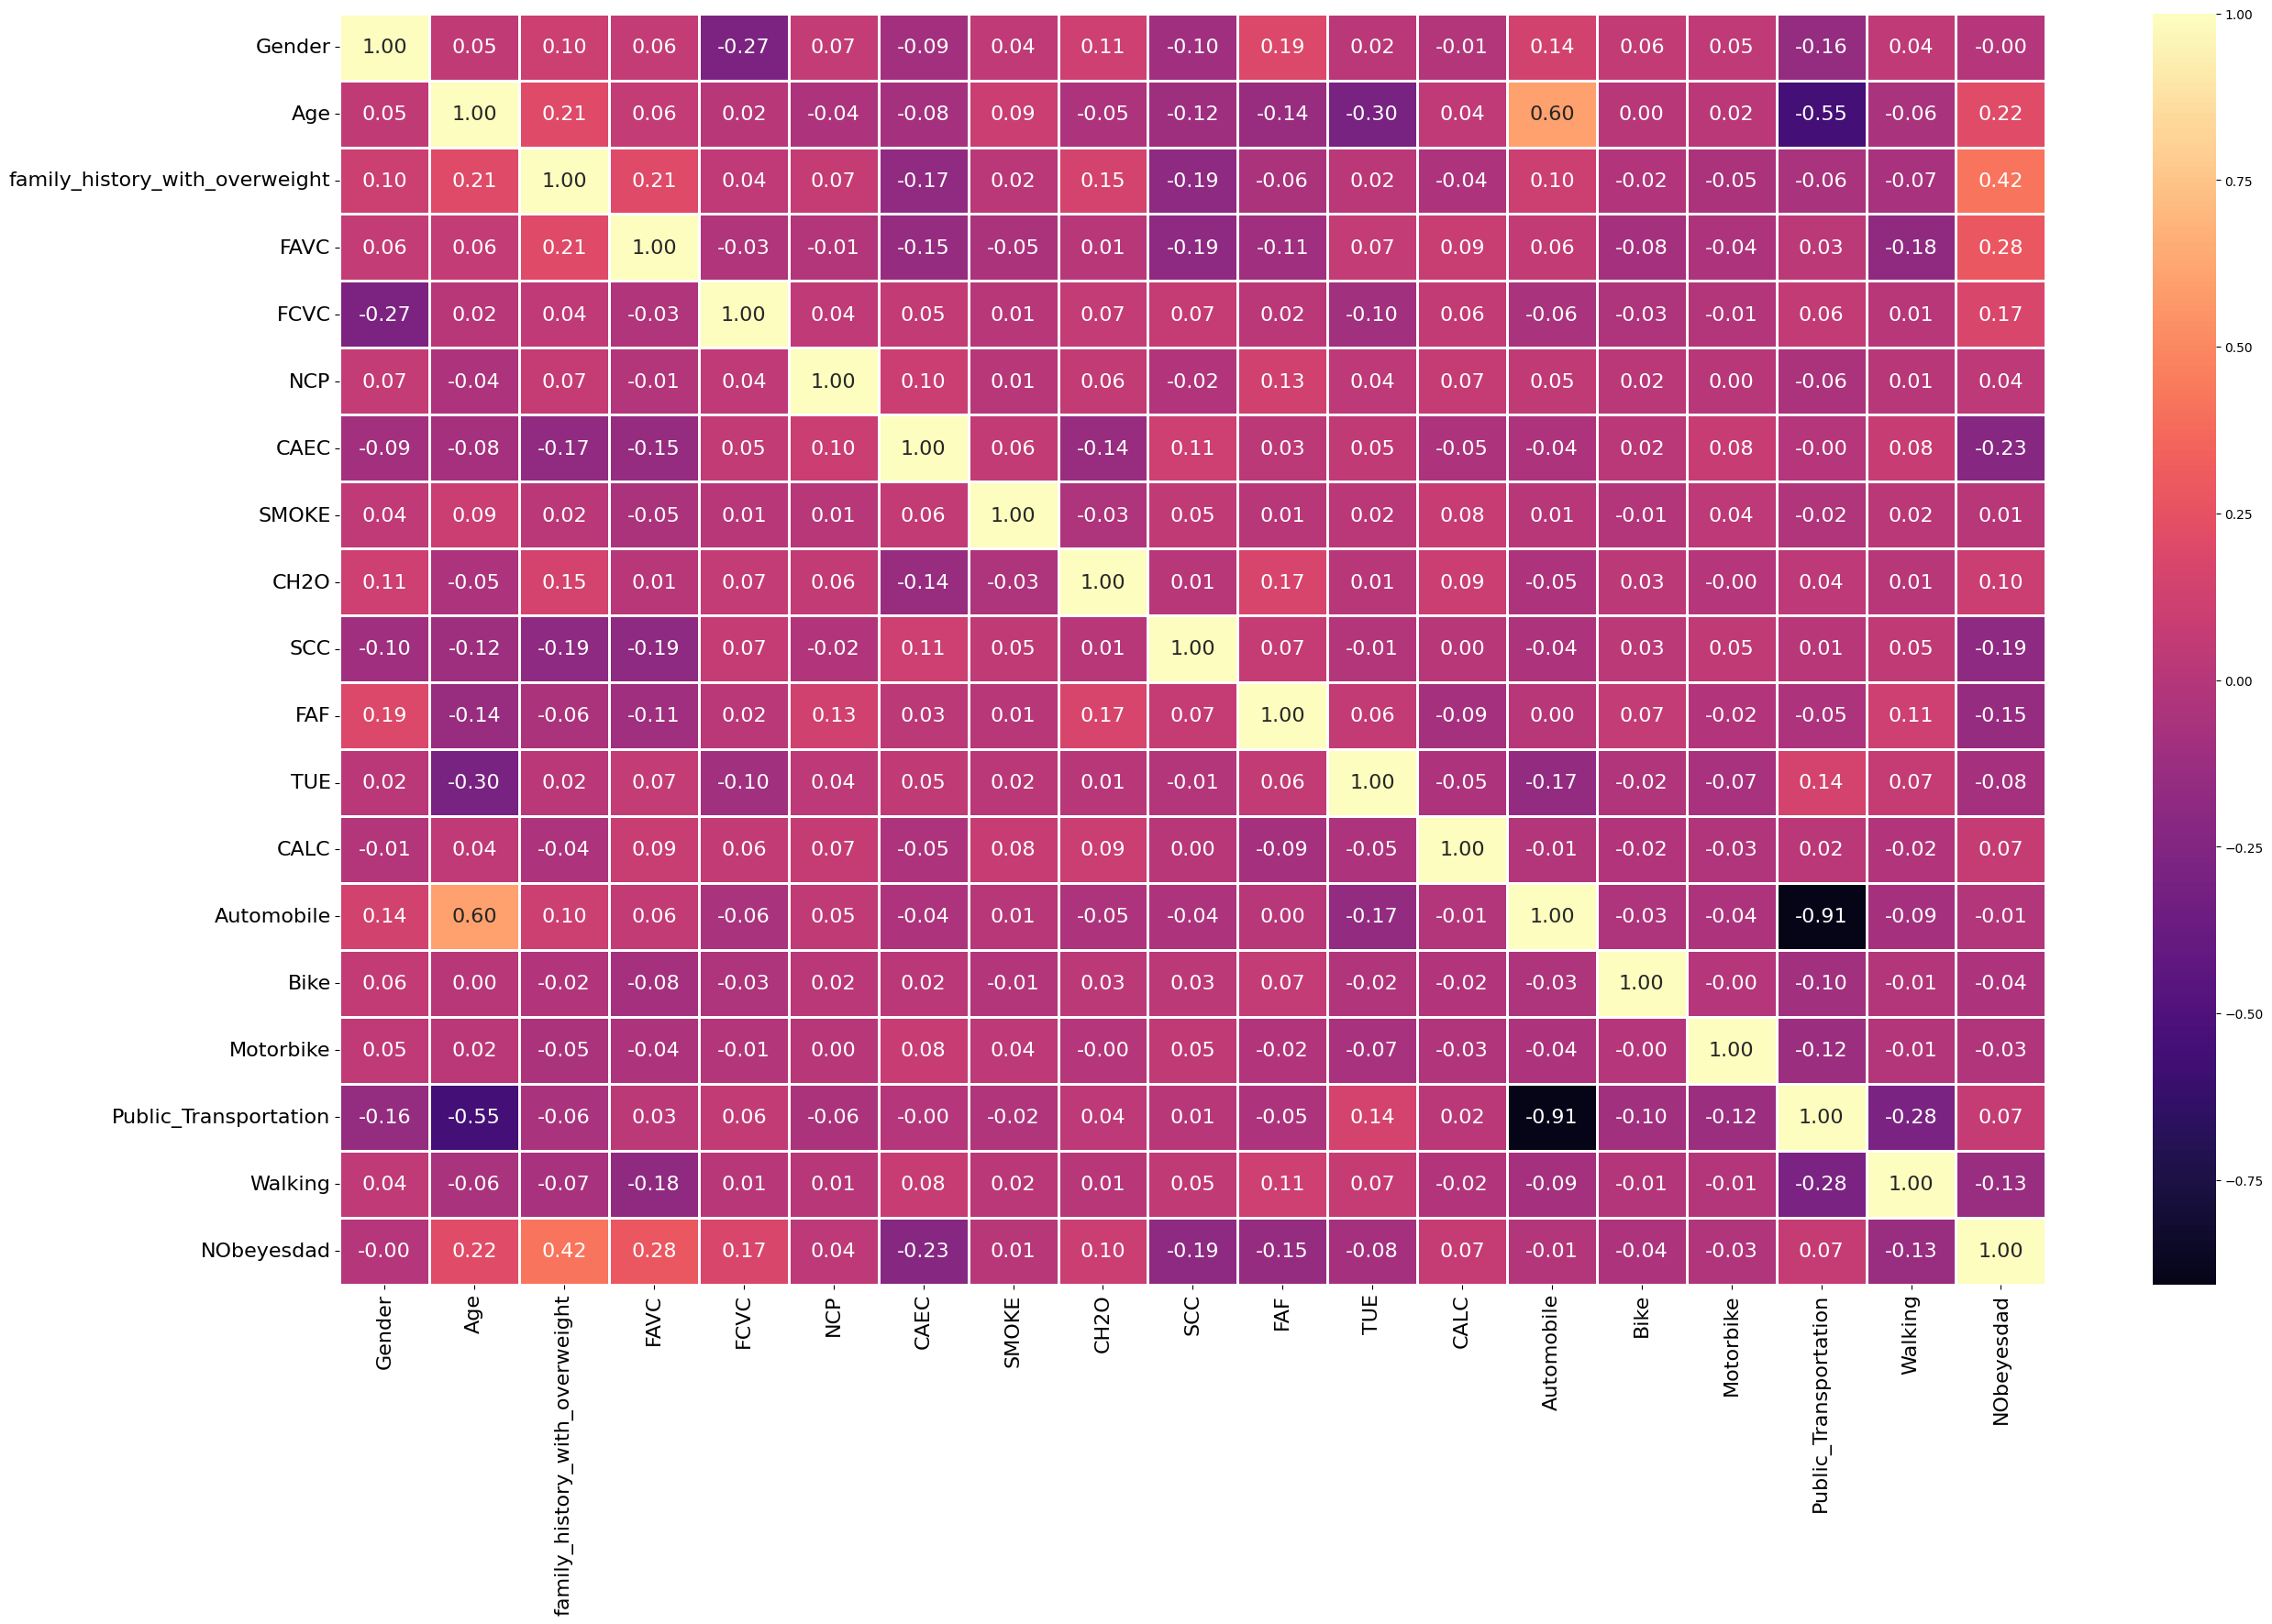

In [36]:
correlation_dataframe = obesity.corr()

plt.figure(figsize=(30,18))
sns.heatmap(data=correlation_dataframe, 
            xticklabels=correlation_dataframe.columns,
            yticklabels=correlation_dataframe.columns,  
            annot=True,
            annot_kws= {'size': 16}, 
            cmap= 'magma',
            linewidths=1,
            center=0,
            fmt='.2f')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()



It does appear that the data does have some big differences in scales, although there are only certain features with a large difference between it and the other features. 



In order to use a linear regression model, we need to split the data into two parts: the predictor variables and an outcome variable. We can do this by splitting the data into a DataFrame of predictor variables called `X` and a Series of outcome variables `y`.

In [51]:
## We need to split the data into features and labels. 
y = obesity['NObeyesdad']
X = obesity.drop(columns=['NObeyesdad'])


## Ensuring that we have removed the labels from the feature dataframe.
print(X.columns)

## Ensuring that we have a series of labels.
print(y)

Index(['Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'FCVC',
       'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC',
       'Automobile', 'Bike', 'Motorbike', 'Public_Transportation', 'Walking'],
      dtype='object')
0       0
1       0
2       0
3       0
4       0
       ..
2106    1
2107    1
2108    1
2109    1
2110    1
Name: NObeyesdad, Length: 2111, dtype: int64


### Logistic regression model

We are going to ceate a logistic regression model called `lr`, including the parameter `max_iter=1000` to make sure that the model will converge when we try to fit it.

In [52]:
## Creating the model. 
lr = LogisticRegression(max_iter=1000)

## Fitting the model to the data. 
lr.fit(X, y)

LogisticRegression(max_iter=1000)

### Model accuracy

A model's _accuracy_ is the proportion of classes that the model correctly predicts. We are going to compute and print the accuracy of logistic regressor by using the .score() method on the training data to see how it performs.

In [53]:
## Getting the accuracy score for the lr on the training dataset. 
print(lr.score(X, y))

0.7659876835622927


Okay so without any feature selection methods applied, our model scored 76% on the dataset, this is good, but not great, lets see if we can improve our accuracy using different wrapper feature selection methods.

It is also worth noting that this is on the TRAINING DATA, this is a rather poor way to actually test our model but this is what code academy is asking us to do, a better way would be to use k-fold-cross-validation, this would allow us to get more representative score of how the model will perform on unseen instances of the training set, rather than using the data that was actually used to train the model.

## Sequential Forward Selection

Now that we have created a logistic regression model and evaluated its performance, we are going to do some feature selection and see if we can improve the models performance! 

To do this we are going to:
- Create a sequential forward selection model called `sfs`. 
- Set the `estimator` parameter to `lr` and set the `forward` and `floating` parameters to the appropriate values to ensure that we are doing the correct wrapper technique. 
- We are going to also use the parameters `k_features=9`, `scoring='accuracy'`, and `cv=0` setting the number of features we want to 9, our evaluation metric to be accuracy and stating we do not want to perform k-fold-cross-validation.

In [54]:

## Creating an instance of the SFS class.
sfs = SFS(estimator=lr, forward=True, floating=False, k_features=9, scoring='accuracy', cv=0)

## Fitting the model to the data. 
sfs.fit(X, y)

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(max_iter=1000),
                          k_features=(9, 9), scoring='accuracy')

In [55]:
## Inspecting the results. 
print(sfs.subsets_[9])

## Getting the tuple of feature names that the algorithm found to achieve the highest accuracy with 9 features. 
print(sfs.subsets_[9]['feature_names'])

## Getting the accuracy of the model that uses the features in the tuple above. 
print(sfs.subsets_[9]['avg_score'])

{'feature_idx': (0, 1, 2, 3, 6, 9, 10, 14, 17), 'cv_scores': array([0.78351492]), 'avg_score': 0.7835149218379914, 'feature_names': ('Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SCC', 'FAF', 'Bike', 'Walking')}
('Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SCC', 'FAF', 'Bike', 'Walking')
0.7835149218379914


A 2% increase in accuracy, this shows that some of the features used in the original model were adding some noise to our predictions inhibiting our model from making optimal predictions, we have moved a step in the right direction, but can we make it better?

### Visualize model accuracy

It can be really helpful to visualize the results of sequential forward selection and see how accuracy is affected as each feature is added. To do this we are going to use the get_metric_dict() method and plot the model accuracy as a function of the number of features used.

/Users/cameronwheeler/Desktop/cameron_repos/CodeAcademy_Projects/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cameronwheeler/Desktop/cameron_repos/CodeAcademy_Projects/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


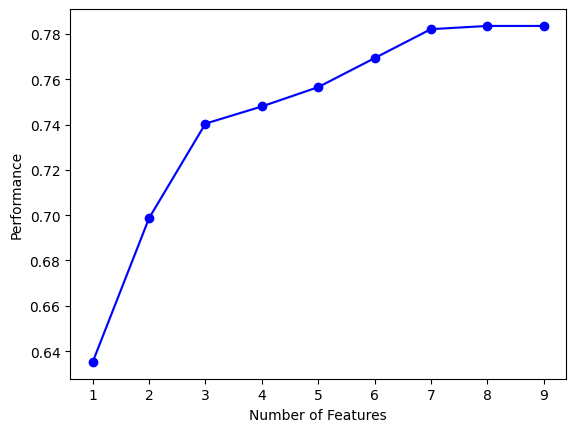

In [56]:

## Plotting the accuracy as a function of features used.
plot_sfs(sfs.get_metric_dict())
plt.show()

We can see that as we increase the number of features used, our models performance increases. However it looks like the performance starts to plateau at after 7 features are added to the model. 

## Sequential Backward Selection

Sequential forward selection was able to find a feature subset that performed marginally better than the full feature set. We are now going to use a different sequential method and see how it compares.

We are now going to look at sequential backward selection. To do this we are going to:
- Create a sequential backward selection model called `sbs`. 
- Set the `estimator` parameter to `lr` and set the `forward` and `floating` parameters to the appropriate values so we are performing the correct kind of wrapper method.
-  We are also going to use the parameters `k_features=7`, `scoring='accuracy'`, and `cv=0`.

In [57]:
## Creating an instance of the SFS class, setting it to perform backward selection, NOT forward. 
sbs = SFS(estimator=lr, forward=False, floating=False, k_features=7, scoring='accuracy', cv=0)

## Fitting the model. 
sbs.fit(X, y)

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(max_iter=1000),
                          forward=False, k_features=(7, 7), scoring='accuracy')

In [58]:
## Inspecting the results. 
print(sbs.subsets_[7])

## Getting the tuple of feature names that the algorithm found to achieve the highest accuracy with 9 features. 
print(sbs.subsets_[7]['feature_names'])

## Getting the accuracy of the model that uses the features in the tuple above. 
print(sbs.subsets_[7]['avg_score'])

{'feature_idx': (1, 2, 3, 6, 9, 10, 16), 'cv_scores': array([0.76740881]), 'avg_score': 0.7674088109900521, 'feature_names': ('Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SCC', 'FAF', 'Public_Transportation')}
('Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SCC', 'FAF', 'Public_Transportation')
0.7674088109900521


We can see that we actually lost some performance by changing the algorithm from forward to backward selection (it will be worth seeing the performance when the feature set limit was 9). It is also interesting to compare the features selected by the two different algorithms SFS selected 'Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SCC', 'FAF', 'Bike' and 'Walking' as it features. While SBS selected 'Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SCC', 'FAF' and 'Public_Transportation'. 

/Users/cameronwheeler/Desktop/cameron_repos/CodeAcademy_Projects/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cameronwheeler/Desktop/cameron_repos/CodeAcademy_Projects/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


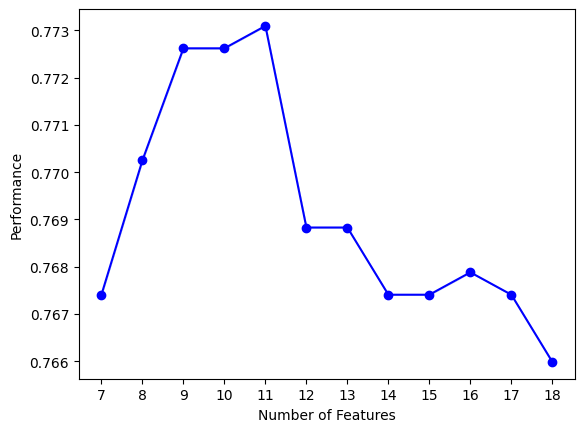

In [59]:
## Visualize model accuracy. 
plot_sfs(sbs.get_metric_dict())
plt.show()

We can easily see that 7 features does not provide the best performance when using sbs, if we wanted to use sbs it would be better to use around 11 features and rerun the algorithm several times to ensure that we have selected the right set and amoubt of features to optimize performance.  but it is also worth noting that the top model performance still under-performs against the sfs algorithm that we used before.

## Recursive Feature Elimination

So far we have tried two different sequential feature selection methods. Let's try one more: recursive feature elimination. Before using RFE it is essential that we standardize our data, then we can fit the RFE model and inspect the results, just like we have done with the other wrapper methods.

At a later step of this project, we are told we will need to be able to access feature names, so we need to make sure we save them. 

In [60]:
## Saving the feature names. 
features = X.columns

## Standardizing the data. 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)


## Creating an RFE instance, we want to select 8 features to use in our model. Fit the model to the data.
rfe = RFE(estimator=lr, n_features_to_select=8)
rfe.fit(X, y)


RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=8)

### Inspect chosen features

Now that we have fit the RFE model we can evaluate the results we are going to create a list of chosen feature names and call it `rfe_features`.  We are then going to see which out of the original features the model selected based on whether their support is `True` (meaning the model kept them) or `False` (meaning the model eliminated them).

In [61]:
rfe_features = rfe.support_
what_features_were_chosen = [feature for (feature, bool_) in zip(features, rfe_features) if bool_ == True]

what_features_were_chosen

['family_history_with_overweight',
 'FAVC',
 'FCVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'Motorbike',
 'Walking']

### Model accuracy

We can use the `.score()` method on `rfe` instance and print the model accuracy after doing recursive feature elimination.

In [62]:
print(rfe.score(X, y))

0.7399336807200378


So RFE has not performed as well as the other types of feature selection algorithms, to improve our performance using this algorithms, we could take the time to try and tune the hyperparamter values for RFE. 